# Model selection

``dualbounds`` comes equipped with three methods for selecting a good choice of outcome model, yielding tight and valid confidence bounds. Our recommendations are summarized below:

1. Use the multiplier bootstrap if (a) the data come from a randomized experiments and (b) one plans to use a ``DualBounds`` or ``DualIVBounds`` class.
2. Within-fold model selection by cross-validation is recommended in all other scenarios (particularly observational studies).
3. One can also define customized model selectors using different metrics. However, this is not our recommended approach.

## Method 1: the multiplier bootstrap

In randomized experiments, ``DualBounds`` produces valid confidence intervals under arbitrary misspecification of the outcome model, meaning that the analyst can try many different outcome models to see which produces the tightest bounds. The multiplier bootstrap provides a principled way to combine evidence across many different estimates while retaining rigorous coverage guarantees for the final confidence interval (i.e., accounting for multiplicity).

Below, we show how to do this in challenging setting with heteroskedasticity.

In [1]:
# Import packages
import sys; sys.path.insert(0, "../../../")
import numpy as np
import dualbounds as db
from dualbounds.generic import DualBounds
# Generate synthetic data from a linear model with heteroskedasticity
data = db.gen_data.gen_regression_data(
    n=900, # Num. datapoints
    p=30, # Num. covariates
    tauv=0.2,
    interactions=True, # ensures treatment effect is heterogenous
    heterosked='exp_linear', # Pattern of heteroskedasticity
    eps_dist='laplace',
    sample_seed=123, # random seed
)

First, we compute dual bounds based on several different choices of outcome model.

In [2]:
# Nominal level
alpha = 0.1
# List of dualbounds objects
db_objects = []
widths = []
Y_models = ['ridge', 'rf']
heterosked_models = ['none', 'lasso', 'rf']
model_names = []
for Y_model in Y_models:
    for heterosked_model in heterosked_models:
        print(f"Fitting outcome_model={Y_model}, heterosked_model={heterosked_model}.")
        gdb = DualBounds(
            # data
            outcome=data['y'],
            treatment=data['W'], 
            covariates=data['X'],
            propensities=data['pis'],
            # estimand
            f=lambda y0, y1, x: y0 < y1,
            # models
            outcome_model=Y_model,
            heterosked_model=heterosked_model,
            eps_dist='laplace',
        )
        gdb.fit(nfolds=3, alpha=alpha, verbose=False)
        db_objects.append(gdb)
        widths.append(gdb.cis[1] - gdb.cis[0])
        model_names.append(f'Y_model={Y_model}\nHeterosked={heterosked_model}')

Fitting outcome_model=ridge, heterosked_model=none.
Fitting outcome_model=ridge, heterosked_model=lasso.
Fitting outcome_model=ridge, heterosked_model=rf.
Fitting outcome_model=rf, heterosked_model=none.
Fitting outcome_model=rf, heterosked_model=lasso.
Fitting outcome_model=rf, heterosked_model=rf.


Second, we aggregate the bounds using the multiplier bootstrap.

In [3]:
bootstrap_output = db.bootstrap.dualbound_multiplier_bootstrap(
    db_objects, alpha=alpha
)
print(bootstrap_output.to_markdown())

|            |    Lower |    Upper |
|:-----------|---------:|---------:|
| Estimate   | 0.702693 | 0.867295 |
| Conf. Int. | 0.65669  | 0.902071 |


We can see that the bootstrap output width is nearly equal to the smallest width among all methods.

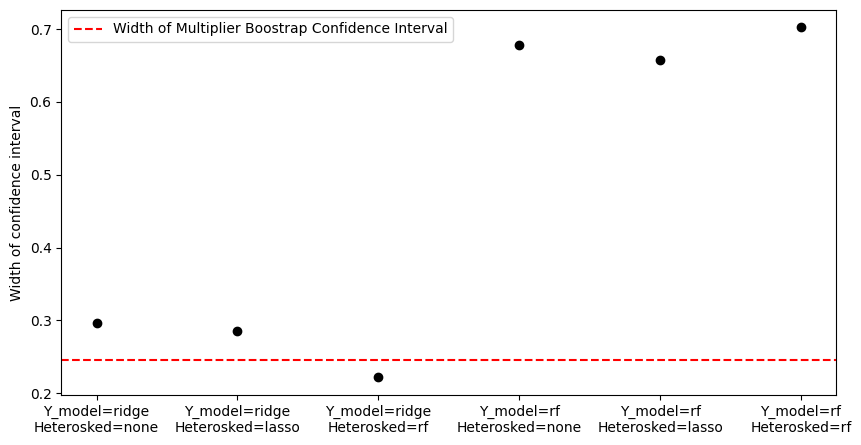

In [4]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))
bootstrap_width = bootstrap_output.values[1, 1] 
bootstrap_width -= bootstrap_output.values[1, 0]
ax.scatter(model_names, widths, color='black')
ax.axhline(
    bootstrap_width, 
    label='Width of Multiplier Boostrap Confidence Interval', 
    color='red',
    linestyle='dashed',
)
ax.set(ylabel="Width of confidence interval")
ax.legend()
plt.show()

## Method 2: Within-fold model selection via cross-validation

The multiplier bootstrap is computationally cheap and statistically powerful. However, it has two limitations:

1. It is not appropriate in observational studies, where the validity of the final dual bounds may depend on the accuracy of the outcome model. Thus, in observational studies, the multiplier bootstrap could select a low-quality outcome model which yields misleadingly tight bounds.
3. It only applies to ``DualBounds`` and ``DualIVBounds`` objects; it will not work with ``DeltaDualBounds`` objects.

The default alternative in ``DualBounds`` is to use nested cross-validation. In particular, if one passes a ``DualBounds`` object a *list* of possible outcome models, on each fold it will pick the model with the lowest cross-validated prediction error.

Below, we consider a simple example where we are choosing between a ridge and random forest. The model selection procedure automatically achieves the performance of the best model (in this case the ridge regression).

In [5]:
# Generate synthetic data from a linear model
data = db.gen_data.gen_regression_data(n=300, p=20, r2=0.5, tau=0)
# Common arguments for each DualBounds class
db_args = dict(
    # Define the estimand as E[Y(1) - Y(0) | Y(0) > 0].
    f=lambda y0, y1, x: (y1 - y0) * (y0 > 0),
    h=lambda fval, z0, z1: fval / z0,
    z0=lambda y0, x: (y0 > 0).astype(float),
    z1=lambda y1, x: 0,
    # Input the data
    outcome=data['y'], 
    covariates=data['X'], 
    treatment=data['W'],
)
# Use model selection to pick between ridge and random forest
gdb_selected = db.delta.DeltaDualBounds(**db_args, outcome_model=['ridge', 'rf']).fit(verbose=False)
# Compare to ridge and random forest alone
gdb_ridge = db.delta.DeltaDualBounds(**db_args, outcome_model='ridge').fit(verbose=False)
gdb_rf = db.delta.DeltaDualBounds(**db_args, outcome_model='rf').fit(verbose=False)

In [6]:
print("The performance of the model selection procedure is:")
print(gdb_selected.eval_outcome_model().to_markdown())
print("The performance of the ridge is:")
print(gdb_ridge.eval_outcome_model().to_markdown())
print("The performance of the random forest is:")
print(gdb_rf.eval_outcome_model().to_markdown())

The performance of the model selection procedure is:
|                   |    Model |   No covariates |
|:------------------|---------:|----------------:|
| Out-of-sample R^2 | 0.326337 |         0       |
| RMSE              | 1.06393  |         1.29626 |
| MAE               | 0.84449  |         1.0484  |
The performance of the ridge is:
|                   |    Model |   No covariates |
|:------------------|---------:|----------------:|
| Out-of-sample R^2 | 0.326337 |         0       |
| RMSE              | 1.06393  |         1.29626 |
| MAE               | 0.84449  |         1.0484  |
The performance of the random forest is:
|                   |    Model |   No covariates |
|:------------------|---------:|----------------:|
| Out-of-sample R^2 | 0.240912 |         0       |
| RMSE              | 1.12938  |         1.29626 |
| MAE               | 0.894703 |         1.0484  |


<div class="alert alert-block alert-info"> <b>Note: "Within-fold" cross validation means that DualBounds will perform cross validation separately for each fold of the data. For example, when using nfolds=5, DualBounds will perform cross-validation 5 separate times. Although this can be computationally expensive on large datasets, it is important to prevent overfitting and ensure the final bounds are valid.</b> </div>

## Method 3: Custom within-fold model selection

``dualbounds`` can flexibly wrap around many other types of model selection procedures. In particular, an abbreviated outline of the ``dualbounds`` algorithm is:

1. Split the data into $K$ disjoint folds $[n] = D_1 \cup \dots \cup D_K$.
2. For $k \in [K]$:
   1. Fit an outcome model on every fold of data except $D_k$.
   2. Evaluate the outcome model out-of-sample on $D_k$ and convert its predictions into dual bounds.

Given a set of potential outcome models, in Step 2(a), one can use any model selection procedure to choose between them, as long as they do not "cheat" by looking at the held-out fold $D_k$. We recommend using nested-cross validation, but users can implement any other model selection metric they like by wrapping the ``db.dist_reg.ModelSelector`` class.

For example, below, we consider the following model selection procedure: in Step 2(a), we re-run the entire dual-bounds procedure  and pick the outcome model which yields the tightest bounds.

We now show how to use this approach when estimating (e.g.) the Variance of the ITE. The main step is to define a custom ModelSelector class with a ``select_model`` method, as shown below. It is important that the ``select_model`` class has exactly this signature.

In [7]:
from typing import Optional
class VarITEModelSelector(db.dist_reg.ModelSelector):
    
    def select_model(
        self,
        models: list[db.dist_reg.DistReg],
        W: np.array,
        X: np.array,
        y: np.array,
        Z: Optional[np.array]=None,
        sample_weight: Optional[np.array]=None,
        propensities: Optional[np.array]=None,
        **kwargs
    ) -> db.dist_reg.DistReg:
        """
        Selects one among many DistReg models.
        """
        # Print
        print("Selecting model for VarITE.")
        # for each model, fit VarITEDualBounds and select the model
        # which produces the tightest bounds.
        widths = np.zeros(len(models))
        for i, model in enumerate(models):
            vdb = db.varite.VarITEDualBounds(
                outcome=y, covariates=X, treatment=W, propensities=propensities,
                outcome_model=model,
            )
            vdb.fit(nfolds=5, verbose=False)
            widths[i] = vdb.cis[1] - vdb.cis[0]
        # Select the tightest lower bound
        jopt = np.argmax(widths)
        return models[jopt]

Once we have defined the ModelSelector, we can simply pass it to a parent ``VarITEDualBounds`` object and let it choose between the various outcome models.

In [8]:
data = db.gen_data.gen_regression_data(n=300, p=10, r2=0.5, interactions=False, sample_seed=123)

import sklearn.ensemble
vdb_parent = db.varite.VarITEDualBounds(
    outcome=data['y'],
    treatment=data['W'],
    propensities=data['pis'],
    covariates=data['X'],
    # choose between 4 types of outcome models
    outcome_model=[
        db.dist_reg.CtsDistReg('lasso', how_transform='interactions'),
        db.dist_reg.CtsDistReg('ridge', how_transform='interactions'),
        db.dist_reg.CtsDistReg('lasso', how_transform='identity'),
        db.dist_reg.CtsDistReg('knn', how_transform='identity', n_neighbors=50),
    ],
    model_selector=VarITEModelSelector(),
)
vdb_parent.fit(nfolds=5)
print(vdb_parent.results().to_markdown())

Cross-fitting the outcome model.


  0%|          | 0/5 [00:00<?, ?it/s]

Selecting model for VarITE.
Selecting model for VarITE.
Selecting model for VarITE.
Selecting model for VarITE.
Selecting model for VarITE.
Estimating optimal dual variables.


  0%|          | 0/300 [00:00<?, ?it/s]

|            |    Lower |    Upper |
|:-----------|---------:|---------:|
| Estimate   | 0        | 5.7599   |
| SE         | 0.748058 | 0.462774 |
| Conf. Int. | 0        | 6.66692  |


One can see that the message "Selecting model for VarITE" is printed 5 times---this is because ``dualbounds`` is performing model selection separately for each fold of data. This leads to honest estimates that do not overfit, although it is computationally expensive for large datasets.